In [ ]:
#In this work, the 171 electrode's channels are considered as nodes, and edges are the respective connections.
#For the creation and study of complex networks, we used the package NetworkX.
#We divided the the FFT of the data in 1 Hz intervals obtaining 150 network which represent the correlation of channels computed within frequency intervals of 1Hz.
#Neural interactions have been assessed computing the Pearson correlation coefficient (Pcc), using the pearsonr function from the scipy.stats library.
#We performed the Bonferroni test, using the statsmodels.stats.multitest.multipletests function, in order to eliminate multiple spurious positives.  Once the corrected Pcc was calculated, we built the adjacency matrix (M).
#For each network we computed different centrality measures and we performed a Mann-Whitney U test, computing the normalized statistic for each measure to assess their effectiveness in distinguishing between epileptic and non-epileptic channels.

#In a parallel analysis, we used the Louvain algorithm to cluster the nodes in order to assess how distinctly the networks separated epileptic from non-epileptic channels. To measure the goodness of our clustering algorithm, we computed the v_measure_score which is a symmetric metric corresponding to the harmonic mean between homogeneity and completeness.
#We used this metric in order to evaluate:
#-how well the predicted clusters represent the epileptogenic and non-epileptogenic classes.
#-the connection between the predicted clusters and the electrodes. This should ideally be similar to the relationship between actual epileptogenic and non-epileptogenic classes and the electrodes.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import csv
from scipy.optimize import curve_fit
from scipy.fft import fft
from scipy import signal
from scipy.signal import iirnotch, lfilter
from scipy.signal import butter, filtfilt
import os
import networkx as nx
from scipy import stats
from scipy.stats import pearsonr
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.multitest import multipletests
from scipy.signal import find_peaks
import statistics
from scipy.signal import peak_widths
from sklearn.metrics import mutual_info_score
import matplotlib.patches as mpatches
from scipy.signal import butter, lfilter
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import networkx as nx
from community import community_louvain
from networkx.algorithms import community
from matplotlib.colors import ListedColormap
from sklearn.metrics import homogeneity_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import v_measure_score
from scipy.stats import mannwhitneyu, norm



In [18]:
#GRAPHIC SETTINGS
sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=9)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rcParams['lines.linewidth'] = 0.5
plt.rc('font', size=13)          # controls default text sizes

def divide_in_seconds(data, sample_rate):   #funziona valida anche per dividere le frequenze
    samples_per_second = sample_rate
    divided_data = [data[i:i+samples_per_second] for i in range(0, len(data), samples_per_second)]

    return divided_data

# Funzione per salvare ogni array in un file CSV separato
def save_arrays_to_csv(arrays,file_name,folder):
    csv_file_name = f'{folder}/{file_name}.csv'   
    with open(csv_file_name, 'w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow([file_name])
            writer.writerows([[value] for value in arrays[0:]])

    

In [19]:
folder_path_0 = 'dati_finali_NON_EPI_fft'
folder_path_1 = 'dati_finali_EPI_fft'
folder_path_freq = 'freq'

NON_EPI = []
NON_EPIcsv = []
EPI = []
EPIcsv = []
labels_0 = []
labels_1 = []

filenames_0 = [f for f in os.listdir(folder_path_0) if os.path.isfile(os.path.join(folder_path_0, f))]
filenames_1 = [f for f in os.listdir(folder_path_1) if os.path.isfile(os.path.join(folder_path_1, f))]
filenames_freq = [f for f in os.listdir(folder_path_freq) if os.path.isfile(os.path.join(folder_path_freq, f))]

for filename_0 in filenames_0:
    file_path_0 = os.path.join(folder_path_0, filename_0)
    df_0 = pd.read_csv(file_path_0)
    NON_EPIcsv.append(df_0)
    labels_0.append(df_0.columns[0])
    for col_0 in df_0.columns:
        array_0 = df_0[col_0].values
        NON_EPI.append(array_0)
        
for filename_1 in filenames_1:
    file_path_1 = os.path.join(folder_path_1, filename_1)
    df_1 = pd.read_csv(file_path_1)
    EPIcsv.append(df_1)
    labels_1.append(df_1.columns[0])
    for col_1 in df_1.columns:
        array_1 = df_1[col_1].values
        EPI.append(array_1)

for filename_freq in filenames_freq:
    file_path_freq = os.path.join(folder_path_freq, filename_freq)
    df_freq = pd.read_csv(file_path_freq)
    for col_freq in df_freq.columns:
        array_freq = df_freq[col_freq].values
        freq=array_freq
     
data_unsorted=NON_EPI+EPI
labels=labels_0+labels_1

combined = list(zip(labels, data_unsorted))
combined_sorted = sorted(combined, key=lambda x: x[0])
labels_tot, data = zip(*combined_sorted)
labels_tot = list(labels_tot)
data = list(data)

Fs = 500.0
Ts = 1.0/Fs
t = np.arange(len(col_0[0])) / Fs
print(len(EPI[0]))
print(len(freq))
print(freq)
print(labels_tot)
n=1500 #Numero di valori dentro ad ogni sottogruppo (1500 significa che divido in intervalli di 1Hz)
len_data_array=len(data[0])
print("numeri di misure per ogni canale (istanti di tempo):",len_data_array)
intervals_max=int(len_data_array/n) #max intervalli temporali che posso considerare
print("max intervalli temporali che posso considerare:",intervals_max)
labels_dict = {i: label for i, label in enumerate(labels_tot)}


cartella = "frequency_domain_network_output(1Hz)"
os.makedirs(cartella, exist_ok=True)


375001
375001
[0.00000000e+00 6.66666667e-04 1.33333333e-03 ... 2.49998667e+02
 2.49999333e+02 2.50000000e+02]
['A1', 'A10', 'A11', 'A12', 'A13', 'A14', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'F1', 'F10', 'F11', 'F12', 'F2', 'F3', 'F6', 'F7', 'F8', 'F9', 'G1', 'G10', 'G11', 'G12', 'G13', 'G14', 'G2', 'G3', 'G4', 'H1', 'H10', 'H11', 'H12', 'H2', 'H3', 'H4', 'H7', 'H8', 'H9', 'I1', 'I10', 'I2', 'I3', 'I7', 'I8', 'I9', 'J1', 'J14', 'J15', 'J16', 'J17', 'J18', 'J2', 'J3', 'J4', 'J5', 'L1', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'M1', 'M15', 'M16', 'M17', 'M2', 'M3', 'M4', 'M5', 'N1', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'N17', 'N18', 'N2', 'N3', 'N4', 'N5', 'N6', 'O1', 'O10', 'O11', 'O12', 'O13', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'R1', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'R16', 'R2', 'R3', 'R7', 'R8', 'R9', 'T1', 'T2', 'T3', 'T4', 'X1', 'X11', 'X

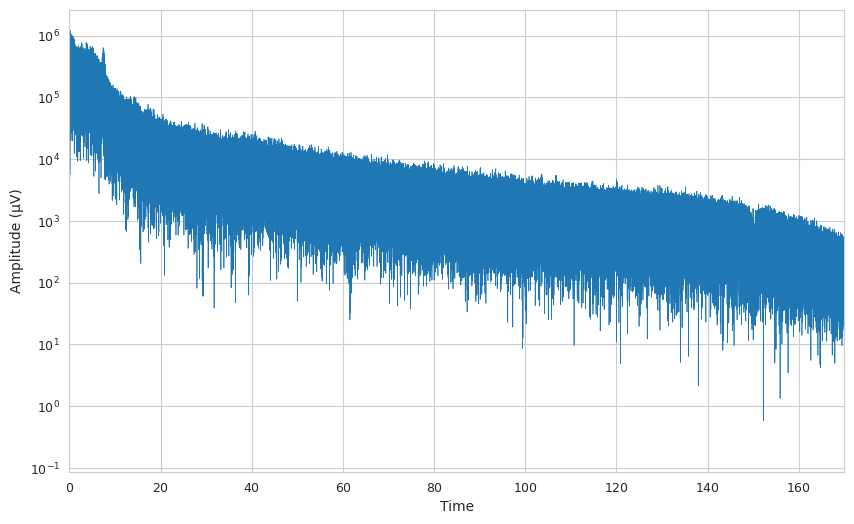

In [4]:
# Plot FFT dei dati filtrati
plt.figure(figsize=(10, 6))
plt.plot(freq,data[0])
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Amplitude (μV)')
plt.xlim(0,170)
plt.grid(True)
plt.show()

In [20]:
divided_fft = []
for array in data:
    divided_d = divide_in_seconds(array, n) #funzione valida anche per dividere le frequenze
    divided_fft.append(divided_d)
    fft_f,fft_a=calculate_fft(divided_d)
    divided_fft.append(fft_a)

divided_freq=divide_in_seconds(freq, n)

first_interval_fft = [array[0] for array in divided_fft]  # Prendiamo i dati del primo intervallo 
n_channels=len(divided_fft)
print("lunghezza di ogni sottointervallo temporale:",len(first_interval_fft[0]))
print("quanti canali stiamo considerand0:",len(divided_fft))
print("lunghezza sottogruppi (quanti intervalli temporali stiamo prendendo):",len(divided_fft[0]))
print(freq[-1])
print(divided_freq[len(divided_freq)-1][-1])
print(len(data))


lunghezza di ogni sottointervallo temporale: 1500
quanti canali stiamo considerand0: 170
lunghezza sottogruppi (quanti intervalli temporali stiamo prendendo): 251
250.0
250.0
170


In [6]:
p_values_all = []  
adjacency_matrices = [] 
Gs=[]
range_len=100
my_range=list(range(0,intervals_max))
# my_range=list(range(range_len,range_len+50))
# for interval in range(len(divided_arrays[0])):# Itera su ogni intervallo di 1 secondo
for interval in my_range:  
    interval_data = [array[interval] for array in divided_fft]  
    correlations = []
    p_values = []
    for i in range(len(interval_data)):
        for j in range(i+1, len(interval_data)):
            corr, p = pearsonr(interval_data[i], interval_data[j])
            correlations.append(corr)
            p_values.append(p)


    num_tests = len(p_values)
    N = n_channels
    alpha_corr=0.05*num_tests*2/(N*(N-1))
    reject, corrected_p_values, _, alpha_2 = multipletests(p_values, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

    # Creo la matrice di adiacenza
    adjacency_matrix = np.zeros((len(interval_data),len(interval_data)))
    k = 0
    for i in range(len(interval_data)):
        for j in range(i+1, len(interval_data)):
            if reject[k]:  # Se la correlazione è significativa
                adjacency_matrix[i, j] = correlations[k]
                adjacency_matrix[j, i] = correlations[k]
            k += 1

    p_values_all.append(corrected_p_values)
    adjacency_matrices.append(adjacency_matrix)

    # Crea il network con NetworkX
    G = nx.from_numpy_array(adjacency_matrix)
    labels_dict = {i: label for i, label in enumerate(labels_tot)}
    nx.set_node_attributes(G, labels_dict, 'label')
    Gs.append(G)

os.makedirs("adjacency_matrices", exist_ok=True)
np.save("adjacency_matrices/adjacency_matrices_1Hz.npy", adjacency_matrices)

In [21]:
#CARICO LE MATRICI DI ADIACENZA SALVATE
adjacency_matrices = np.load("adjacency_matrices/adjacency_matrices_1Hz.npy", allow_pickle=True)
adjacency_matrices_list = adjacency_matrices.tolist()

In [22]:
labels_true = [0] * len(labels_tot)
for i, label in enumerate(labels_tot):
    if label in labels_1:
        labels_true[i] = 1


# Dizionario che associa ogni lettera a un numero
letter_to_number = {
    'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5,
    'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10,
    'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15,
    'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20,
    'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26
}
# Creazione del nuovo array con i numeri corrispondenti
labels_electrodes = [letter_to_number[label[0].upper()] for label in labels_tot]

print(labels_electrodes)
print(labels_true)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 20, 20, 20, 20, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

# Misure di centralità

In [23]:
partitions=[]
partitions_labels=[]
Gs=[]
centrality_measures=[]
my_range=list(range(0,intervals_max))
my_range=my_range[0:150]
adjacency_matrices=adjacency_matrices[0:150]

for interval, matrix in zip(my_range, adjacency_matrices):
    new_matrix = matrix
    new_matrix[new_matrix < 0] = 0
    G = nx.from_numpy_array(new_matrix)
    nx.set_node_attributes(G, labels_dict, 'label')
    Gs.append(G)

centrality_values = {}
for G in Gs:
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    local_clustering = nx.clustering(G)

    for node in G.nodes():
            label = G.nodes[node]['label']
            if label not in centrality_values:
                centrality_values[label] = {'Degree': [], 'Betweenness': [], 'Closeness': [], 'Local clustering': []}    
            centrality_values[label]['Degree'].append(degree_centrality[node])
            centrality_values[label]['Betweenness'].append(betweenness_centrality[node])
            centrality_values[label]['Closeness'].append(closeness_centrality[node])
            centrality_values[label]['Local clustering'].append(local_clustering[node])
    
# Calcolo la media dei valori di centralità per ogni etichetta
average_centrality = {}
for label, values in centrality_values.items():
    average_centrality[label] = {
        'Degree': sum(values['Degree']) / len(values['Degree']),
        'Betweenness': sum(values['Betweenness']) / len(values['Betweenness']),
        'Closeness': sum(values['Closeness']) / len(values['Closeness']),
        'Local clustering': sum(values['Local clustering']) / len(values['Local clustering'])
    }


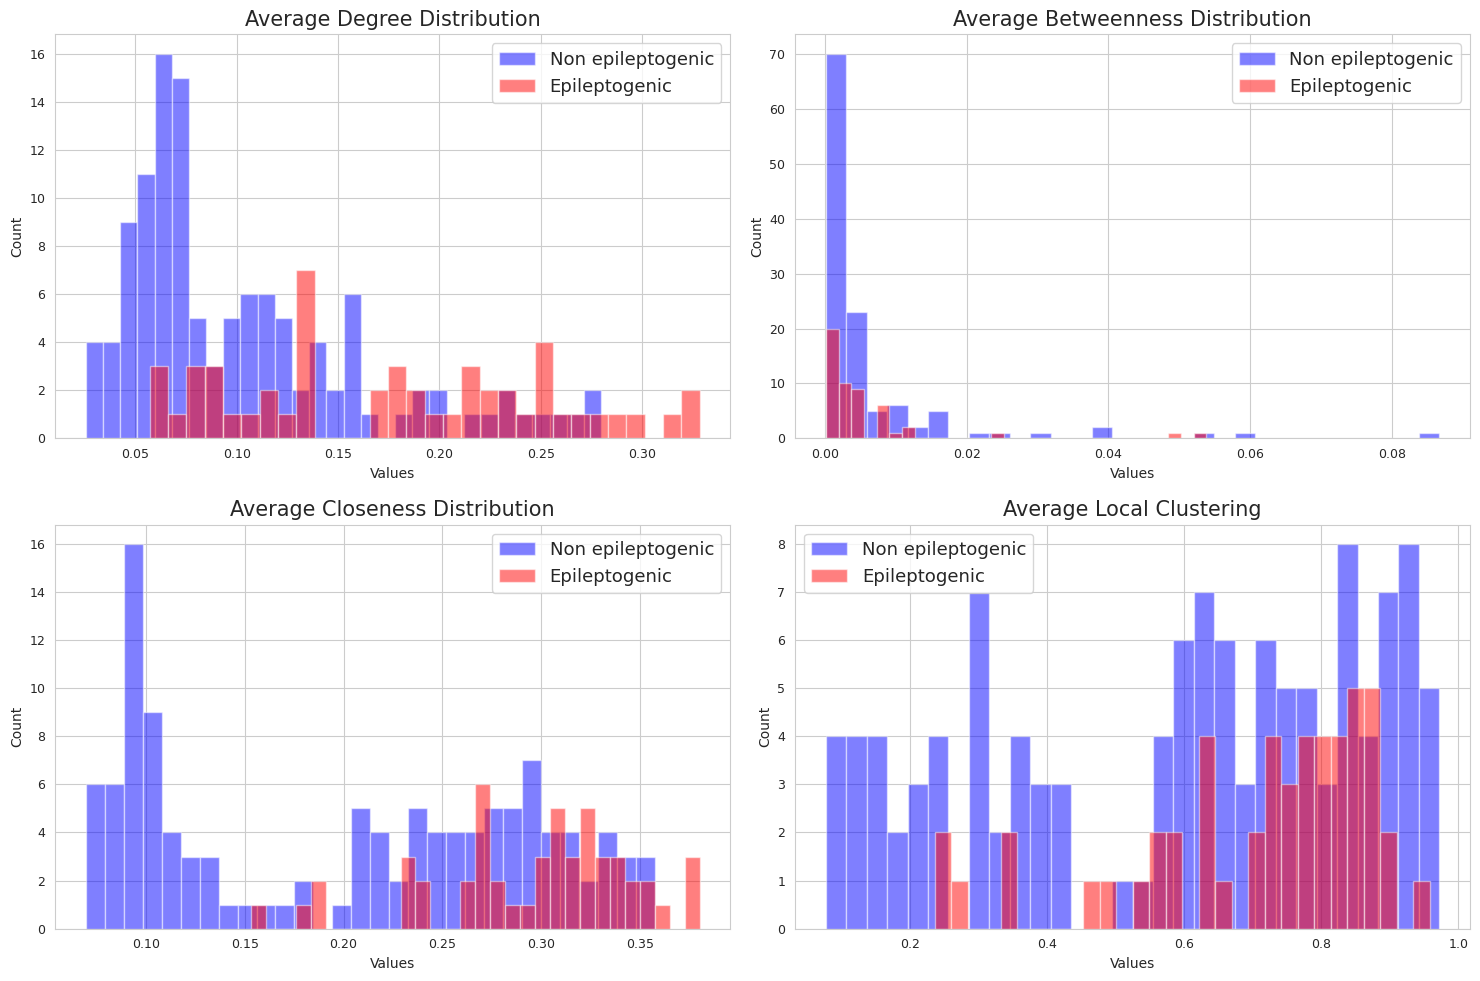

Betweenness   U Statistic: 0.41917943648047457, p-value: 0.09567133329150872
Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.
Closeness   U Statistic: 0.20464656450815621, p-value: 1.1041808126029708e-09
Le due distribuzioni sono significativamente diverse.
Degree   U Statistic: 0.20744768495633548, p-value: 1.582108928546274e-09
Le due distribuzioni sono significativamente diverse.
Local Clustering   U Statistic: 0.3924864063272368, normalized p-value: 0.02661754481601366
Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.


In [24]:
df = pd.DataFrame.from_dict(average_centrality, orient='index')
df.reset_index(inplace=True)
df.columns = ['Label', 'Average Degree', 'Average Betweenness', 'Average Closeness','Average Local Clustering']

# Filtro i dati per label_0 e label_1
df_label_0 = df[df['Label'].isin(labels_0)]
df_label_1 = df[df['Label'].isin(labels_1)]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Degree Distribution
axs[0, 0].hist(df_label_0['Average Degree'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[0, 0].hist(df_label_1['Average Degree'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[0, 0].set_title('Average Degree Distribution')
axs[0, 0].set_xlabel('Values')
axs[0, 0].set_ylabel('Count')
axs[0, 0].legend()

# Betweenness Distribution
axs[0, 1].hist(df_label_0['Average Betweenness'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[0, 1].hist(df_label_1['Average Betweenness'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[0, 1].set_title('Average Betweenness Distribution')
axs[0, 1].set_xlabel('Values')
axs[0, 1].set_ylabel('Count')
axs[0, 1].legend()

# Closeness Distribution
axs[1, 0].hist(df_label_0['Average Closeness'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[1, 0].hist(df_label_1['Average Closeness'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[1, 0].set_title('Average Closeness Distribution')
axs[1, 0].set_xlabel('Values')
axs[1, 0].set_ylabel('Count')
axs[1, 0].legend()

# Distribuzione combinata di Degree, Betweenness e Closeness
axs[1, 1].hist(df_label_0['Average Local Clustering'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[1, 1].hist(df_label_1['Average Local Clustering'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[1, 1].set_title('Average Local Clustering')
axs[1, 1].set_xlabel('Values')
axs[1, 1].set_ylabel('Count')
axs[1, 1].legend()

plt.tight_layout()
nome_file=f'plots_average_centrality_measures.jpg'
percorso_completo = os.path.join(cartella, nome_file)
plt.savefig(percorso_completo, format='jpg', dpi=300)
plt.show()



#------------------------------------------------

n1 = len(df_label_0['Average Local Clustering'])
n2 = len(df_label_1['Average Local Clustering'])

u_stat_b, p_value_b = mannwhitneyu(df_label_0['Average Betweenness'], df_label_1['Average Betweenness'])
u_statistic_normalized_b=u_stat_b/(n1*n2)
print(f"Betweenness   U Statistic: {u_statistic_normalized_b}, p-value: {p_value_b}")
if u_statistic_normalized_b < 0.3 or u_statistic_normalized_b>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")
    
u_stat_c, p_value_c = mannwhitneyu(df_label_0['Average Closeness'], df_label_1['Average Closeness'])
u_statistic_normalized_c=u_stat_c/(n1*n2)
print(f"Closeness   U Statistic: {u_statistic_normalized_c}, p-value: {p_value_c}")
if u_statistic_normalized_c < 0.3 or u_statistic_normalized_c>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")
    
u_stat_s, p_value_s = mannwhitneyu(df_label_0['Average Degree'], df_label_1['Average Degree'])
u_statistic_normalized_s=u_stat_s/(n1*n2)
print(f"Degree   U Statistic: {u_statistic_normalized_s}, p-value: {p_value_s}")
if u_statistic_normalized_s < 0.3 or u_statistic_normalized_s>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")

u_stat_cl, p_value_cl = mannwhitneyu(df_label_0['Average Local Clustering'], df_label_1['Average Local Clustering'])
u_statistic_normalized_cl=u_stat_cl/(n1*n2)
print(f"Local Clustering   U Statistic: {u_statistic_normalized_cl}, normalized p-value: {p_value_cl}")
if u_statistic_normalized_cl < 0.3 or u_statistic_normalized_cl>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")



In [25]:
average_centrality_significative = {}
for label, values in centrality_values.items():
    average_centrality_significative[label] = {
        'Degree': sum(values['Degree']) / len(values['Degree']),
        'Closeness': sum(values['Closeness']) / len(values['Closeness'])
    }

df_ok = pd.DataFrame.from_dict(average_centrality_significative, orient='index')
df_ok.reset_index(inplace=True)
df_ok.columns = ['Label', 'Average Degree (1Hz intervals mean)', 'Average Closeness (1Hz intervals mean)']
print(df_ok)

filename = f"freq_1Hz.csv"
percorso_completo = os.path.join(cartella, filename)
df_ok.to_csv(percorso_completo, index=False)

    Label  Average Degree (1Hz intervals mean)  \
0      A1                             0.238935   
1     A10                             0.153767   
2     A11                             0.154122   
3     A12                             0.112978   
4     A13                             0.115266   
..    ...                                  ...   
165    Z2                             0.229073   
166    Z3                             0.182761   
167    Z4                             0.177002   
168    Z5                             0.248205   
169    Z6                             0.262485   

     Average Closeness (1Hz intervals mean)  
0                                  0.333766  
1                                  0.295537  
2                                  0.295748  
3                                  0.278763  
4                                  0.279862  
..                                      ...  
165                                0.325447  
166                            

# Clustering

In [32]:
partitions=[]
partitions_labels=[]
Gs=[]
homogeneity_scores1 = []
homogeneity_scores2 = []
homogeneity_scores3 = []
ari_scores1 = []
ari_scores2 = []
ari_scores3 = []
v_scores1 = []
v_scores2 = []
v_scores3 = []
my_range=list(range(0,intervals_max))
my_range=my_range[0:150]
adjacency_matrices=adjacency_matrices[0:150]
filtered_partitions=[]

for interval, matrix in zip(my_range, adjacency_matrices):
    interval_freq=[divided_freq[interval]]
    min_freq=divided_freq[interval][0]
    max_freq=divided_freq[interval][-1]    
    print("frequenze da ",min_freq,'a',max_freq,'Hz')
    
    new_matrix = matrix
    new_matrix[new_matrix < 0] = 0
    G = nx.from_numpy_array(new_matrix)
    nx.set_node_attributes(G, labels_dict, 'label')
    Gs.append(G)
    
    partition = community_louvain.best_partition(G,resolution=0.6)
    # Filtrare i cluster con meno di 5 elementi
    filtered_partition = {node: cluster_id for node, cluster_id in partition.items() if list(partition.values()).count(cluster_id) > 10}
    filtered_partitions.append(filtered_partition)
    
    cls = {}
    for node, cluster_id in filtered_partition.items():
        if cluster_id not in cls:
            cls[cluster_id] = []
        cls[cluster_id].append((node, labels_tot[node]))
    
    non_clustered_nodes = [node for node in partition if node not in filtered_partition]
    clustered_nodes = [node for node in partition if node in filtered_partition]
    
    # print(f"Nodi non compresi in nessun cluster di filtered_partition {len(non_clustered_nodes)}: {non_clustered_nodes}")
    # print(f"Nodi compresi nei cluster di filtered_partition {len(clustered_nodes)}:{clustered_nodes}")
    # for node in non_clustered_nodes:
    #     print(non_clustered_nodes)
    #     print(labels_tot[node])
     
    labels_pred = [f"{filtered_partition[node]}" for node in range(len(labels_tot)) if node in filtered_partition]
    num_clusters = len(cls)
    print(f"Numero di cluster: {num_clusters}")


    #-------------------------------------V-MEASURE and homogeneity---------------------------------------

    labels_true_filtered = [labels_true[node] for node in clustered_nodes]
    labels_electrodes_less = [labels_electrodes[node] for node in clustered_nodes]


    # CLASSI EPI-NON EPI vs CLUISTERS
    v_score1= v_measure_score(labels_true_filtered, labels_pred)
    #print(f'V Score classes vs clusters: {v_score1:.3f}')
    v_scores1.append(v_score1) 

    homo1= homogeneity_score(labels_true_filtered, labels_pred)
    homogeneity_scores1.append(homo1) 

    #CLASSI ELETTRODI VS EPI-NON EPI 
    v_score2= v_measure_score( labels_true,labels_electrodes)
    # print(f'V Score electrodes vs epi/non epi: {v_score2:.3f}')
    v_scores2.append(v_score2) 

    homo2= homogeneity_score(labels_true,labels_electrodes)
    homogeneity_scores2.append(homo2) 


    #CLASSI ELETTRODI VS CLUSTERS
    v_score3= v_measure_score(labels_pred,labels_electrodes_less )
    # print(f'V Score electrodes vs clusters: {v_score3:.3f}')
    v_scores3.append(v_score3) 
    
    homo3= homogeneity_score(labels_pred,labels_electrodes_less)
    homogeneity_scores3.append(homo3) 



mean_v1=np.mean(v_scores1)
mean_v2=np.mean(v_scores2)
mean_v3=np.mean(v_scores3)
print(f'V Score classes vs clusters: {mean_v1:.3f}')
print(f'V Score classes vs el: {mean_v2:.3f}')
print(f'V Score cluster vs el: {mean_v3:.3f}')


    
    
    ---------------------------------------GRAFICO------------------------------------
    plt.figure(figsize=(28, 7))
    # Layout del grafo
    seed_value = 42
    pos = nx.spring_layout(G, seed=seed_value)

    # Grafico del clustering
    plt.subplot(131) 

    unique_clusters = list(set(filtered_partition.values()))
    cluster_colors = plt.cm.get_cmap('tab20', len(unique_clusters))  # Usa una mappa di colori predefinita con colori distinti
    cluster_color_map = {cluster_id: cluster_colors(i) for i, cluster_id in enumerate(unique_clusters)}
    
    # Assegna un colore a ciascun nodo
    colors = []
    for node in G.nodes():
        if node in filtered_partition:
            cluster_id = filtered_partition[node]
            colors.append(cluster_color_map[cluster_id])  # Colore in base al cluster
        else:
            colors.append('white')
    
   
    # Disegnare il grafo
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels={i: labels_tot[i] for i in range(len(labels_tot))}, font_size=10)
    plt.title('Clusters')
    
    # Grafico basato su dizionario_0
    plt.subplot(132) 
    plt.title('0-1 Classes')
    node_colors2 = []
    for label in labels_tot:
        if label in labels_0:
            node_colors2.append('lightblue')
        elif label in labels_1:
            node_colors2.append('red')
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors2, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels={i: labels_tot[i] for i in range(len(labels_tot))},font_size=10)
    epileptogenic_patch = mpatches.Patch(color='red', label='epileptogenic nodes')
    non_epileptogenic_patch = mpatches.Patch(color='lightblue', label='non epileptogenic nodes')
    plt.legend(handles=[epileptogenic_patch, non_epileptogenic_patch], loc='upper right')
    
    plt.subplot(133) 
    colors = {'A': 'brown', 'F': 'blue', 'G': 'green', 'H': 'slateblue', 'I': 'purple', 'J': 'indianred', 'L': 'indigo', 'M': 'gold',
              'N': 'forestgreen', 'O': 'coral', 'Q': 'teal', 'R': 'darkmagenta', 'T': 'blueviolet', 'X': 'darkturquoise', 'Y': 'navy', 'Z': 'crimson'}
    labels = labels_tot
    node_colors = [colors[label[0].upper()] if label[0].upper() in colors else 'white' for label in labels]
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels={i: labels_tot[i] for i in range(len(labels_tot))},font_size=10,font_color='black')
    legend_elements = [mpatches.Patch(color=color, label='Electrode ' + letter) for letter, color in colors.items()]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title('Electrodes')
    
    plt.show()
    
    
    # # Creazione del dendrogramma
    # linked = linkage(new_matrix, 'single')
    # plt.figure(figsize=(35, 5))
    # dendrogram(linked, labels=labels_tot)
    # plt.show()
    
    plt.show()
    print()

frequenze da  0.0 a 0.9993333333333332 Hz
Numero di cluster: 1
frequenze da  1.0 a 1.9993333333333327 Hz
Numero di cluster: 2
frequenze da  2.0 a 2.9993333333333334 Hz
Numero di cluster: 5
frequenze da  3.0 a 3.999333333333333 Hz
Numero di cluster: 6
frequenze da  4.0 a 4.999333333333333 Hz
Numero di cluster: 2
frequenze da  5.0 a 5.999333333333333 Hz
Numero di cluster: 4
frequenze da  6.0 a 6.999333333333333 Hz
Numero di cluster: 4
frequenze da  7.0 a 7.999333333333333 Hz
Numero di cluster: 1
frequenze da  8.0 a 8.999333333333333 Hz
Numero di cluster: 4
frequenze da  9.0 a 9.999333333333333 Hz
Numero di cluster: 5
frequenze da  10.0 a 10.999333333333333 Hz
Numero di cluster: 5
frequenze da  11.0 a 11.999333333333333 Hz
Numero di cluster: 6
frequenze da  12.0 a 12.999333333333333 Hz
Numero di cluster: 5
frequenze da  13.0 a 13.999333333333333 Hz
Numero di cluster: 5
frequenze da  14.0 a 14.999333333333333 Hz
Numero di cluster: 5
frequenze da  15.0 a 15.999333333333333 Hz
Numero di clus

## Homogeneity_score e V_meausre_score

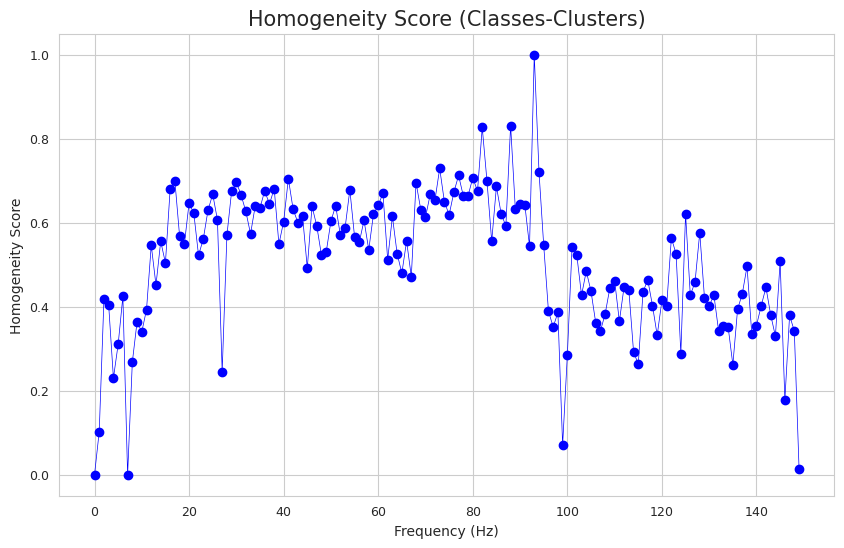

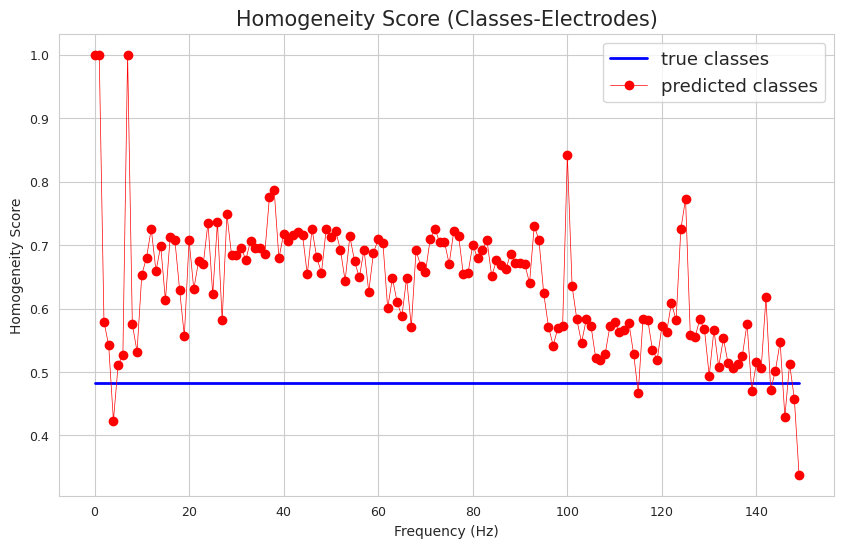

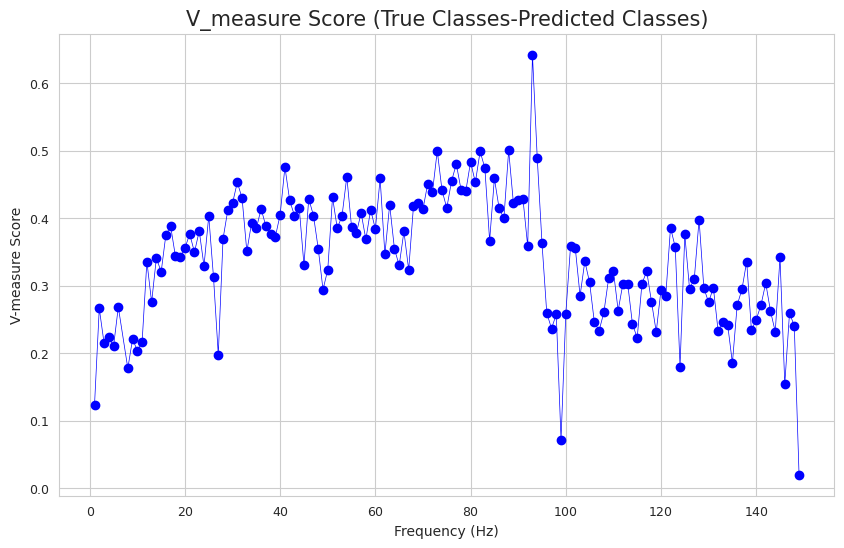

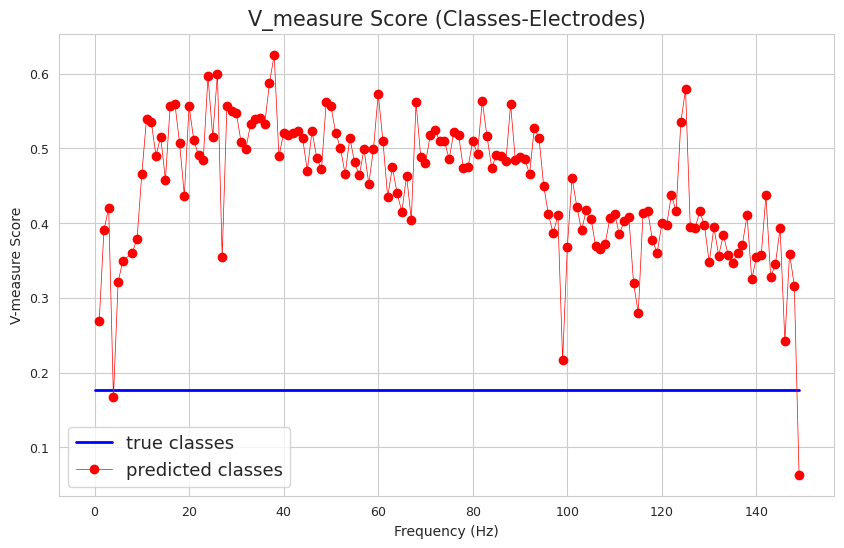

     frequency range (1 Hz)  classes 01 vs clusters  electrodes vs classes 01  \
0                         0                0.000000                  0.176184   
1                         1                0.123133                  0.176184   
2                         2                0.266316                  0.176184   
3                         3                0.215422                  0.176184   
4                         4                0.223381                  0.176184   
..                      ...                     ...                       ...   
145                     145                0.341892                  0.176184   
146                     146                0.154268                  0.176184   
147                     147                0.259869                  0.176184   
148                     148                0.240055                  0.176184   
149                     149                0.020149                  0.176184   

     electrodes vs clusters

In [33]:

# #--------------------------------HOMOGENEITY----------------------
plt.figure(figsize=(10, 6))
plt.plot(my_range, homogeneity_scores1, marker='o', linestyle='-', color='b')

plt.title('Homogeneity Score (Classes-Clusters)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Homogeneity Score')
plt.grid(True)
nome_file = f"homogeneity(classes-clusters)_freq({my_range[0]}-{my_range[-1]} Hz).jpg"
percorso_completo = os.path.join(cartella, nome_file)
plt.savefig(percorso_completo, format='jpg', dpi=300)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(my_range, homogeneity_scores2, linestyle='-',linewidth=2, color='b',label='true classes')
plt.plot(my_range, homogeneity_scores3, marker='o', linestyle='-', color='r',label='predicted classes')
# Aggiungi titoli e etichette agli assi
plt.legend()
plt.title('Homogeneity Score (Classes-Electrodes)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Homogeneity Score')
plt.grid(True)
nome_file=f"homogeneity(electrodes)_freq({my_range[0]}-{my_range[-1]} Hz).jpg"
percorso_completo = os.path.join(cartella, nome_file)
plt.savefig(percorso_completo, format='jpg', dpi=300)
plt.show()


#--------------------------------V MEASURE----------------------

# Filtro i dati per rimuovere i punti con valore zero
filtered_indices_1 = [i for i in range(len(my_range)) if v_scores1[i]!=0]
filtered_indices_2 = [i for i in range(len(my_range)) if v_scores2[i]!=0]
filtered_indices_3 = [i for i in range(len(my_range)) if v_scores3[i]!=0 ]
filtered_range_1 = [my_range[i] for i in filtered_indices_1]
filtered_range_2 = [my_range[i] for i in filtered_indices_2]
filtered_range_3 = [my_range[i] for i in filtered_indices_3]
filtered_v_scores1 = [v_scores1[i] for i in filtered_indices_1]
filtered_v_scores2 = [v_scores2[i] for i in filtered_indices_2]
filtered_v_scores3 = [v_scores3[i] for i in filtered_indices_3]


plt.figure(figsize=(10, 6))
plt.plot(filtered_range_1, filtered_v_scores1, marker='o', linestyle='-', color='b')

plt.title('V_measure Score (True Classes-Predicted Classes)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('V-measure Score')
plt.grid(True)
nome_file = f"v_score(classes-clusters)_freq({my_range[0]}-{my_range[-1]} Hz).jpg"
percorso_completo = os.path.join(cartella, nome_file)
plt.savefig(percorso_completo, format='jpg', dpi=300)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(filtered_range_2, filtered_v_scores2, linestyle='-',linewidth=2, color='b',label='true classes')
plt.plot(filtered_range_3, filtered_v_scores3, marker='o', linestyle='-', color='r',label='predicted classes')
# Aggiungi titoli e etichette agli assi
plt.legend()
plt.title('V_measure Score (Classes-Electrodes)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('V-measure Score')
plt.grid(True)
nome_file=f"v_score(classes-electrodes)_freq({my_range[0]}-{my_range[-1]} Hz).jpg"
percorso_completo = os.path.join(cartella, nome_file)
plt.savefig(percorso_completo, format='jpg', dpi=300)
plt.show()


data = {
    "frequency range (1 Hz)":my_range,
    "classes 01 vs clusters": v_scores1,
    "electrodes vs classes 01": v_scores2,
    "electrodes vs clusters": v_scores3
}

df = pd.DataFrame(data)

# Salvataggio del DataFrame in un file CSV
filename = f"v_scores ({my_range[0]}-{my_range[-1]} Hz).csv"
percorso_completo = os.path.join(cartella, filename)
df.to_csv(percorso_completo, index=False)

print(df)



In [34]:
#TROVO DOVE SI TROVA LO SCORE MASSIMO
max_value = max(v_scores1)
max_position = v_scores1.index(max_value)
# Stampa il valore massimo e la sua posizione
print(f"Valore massimo: {max_value}")
print(f"Posizione: {max_position}")

Valore massimo: 0.6418975422361155
Posizione: 93


frequenze da  93.0 a 93.99933333333333 Hz
Valore massimo: 0.6418975422361155
Nodi non compresi in nessun cluster di filtered_partition 64: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 51, 52, 53, 54, 55, 61, 62, 63, 64, 65, 66, 72, 73, 74, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 149, 150, 151, 152, 153, 154, 155, 156, 157]
Nodi compresi nei cluster di filtered_partition 106:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 56, 57, 58, 59, 60, 67, 68, 69, 70, 71, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169]
Numero di cluster: 4


/tmp/ipykernel_241/83069596.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_colors = plt.cm.get_cmap('tab20', len(unique_clusters))  # Usa una mappa di colori predefinita con colori distinti


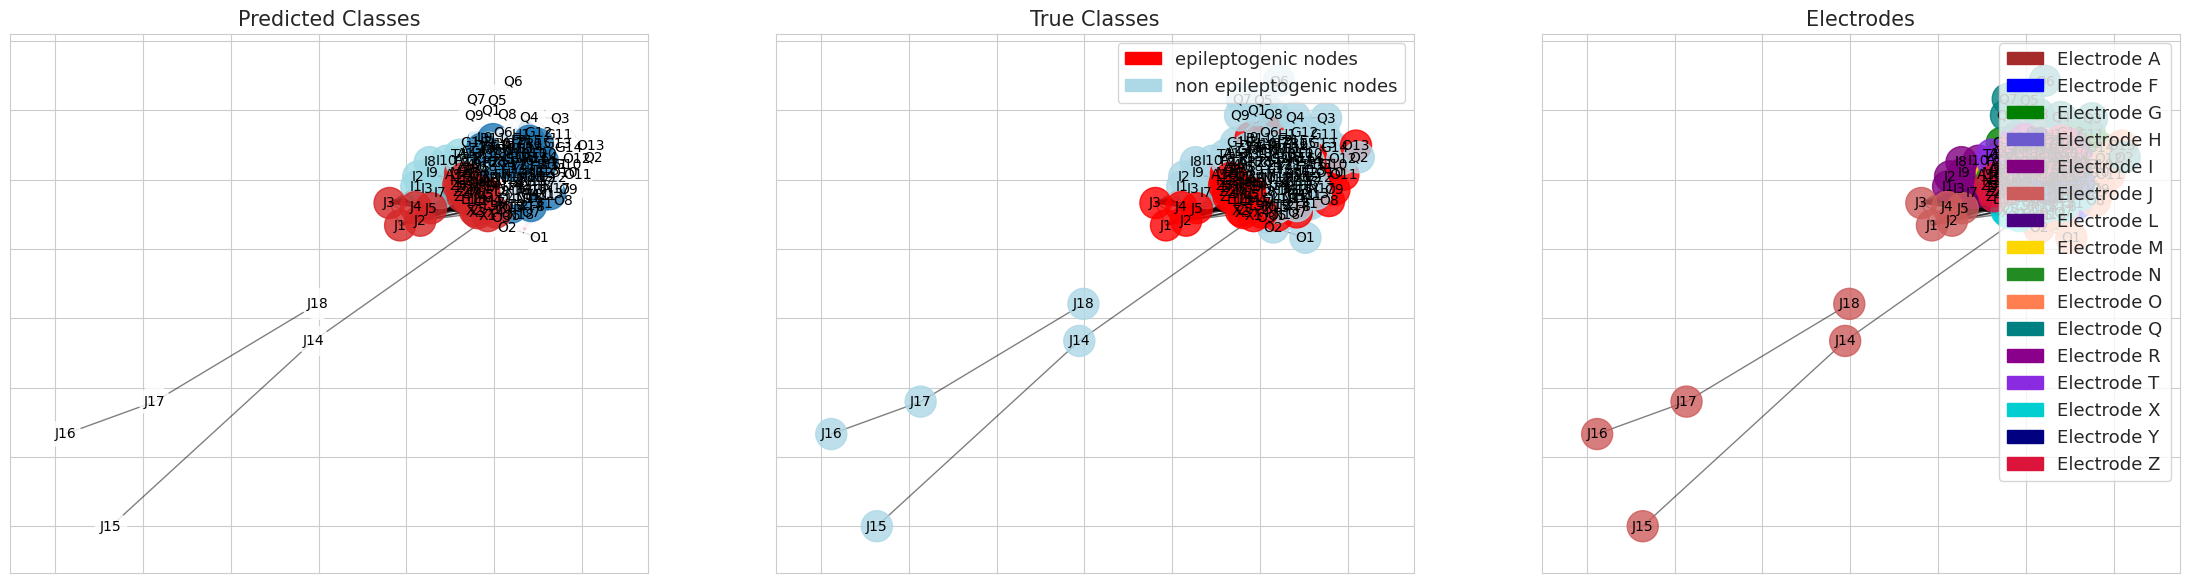

<Figure size 640x480 with 0 Axes>

In [35]:
interval_freq=[divided_freq[max_position]]       
min_freq=divided_freq[max_position][0]
max_freq=divided_freq[max_position][-1]    
print("frequenze da ",min_freq,'a',max_freq,'Hz')
print(f"Valore massimo: {max_value}")
G_max=Gs[max_position]
filtered_partition = filtered_partitions[max_position]

cls = {}
for node, cluster_id in filtered_partition.items():
    if cluster_id not in cls:
        cls[cluster_id] = []
    cls[cluster_id].append((node, labels_tot[node]))

non_clustered_nodes = [node for node in partition if node not in filtered_partition]
clustered_nodes = [node for node in partition if node in filtered_partition]

print(f"Nodi non compresi in nessun cluster di filtered_partition {len(non_clustered_nodes)}: {non_clustered_nodes}")
print(f"Nodi compresi nei cluster di filtered_partition {len(clustered_nodes)}:{clustered_nodes}")
# for node in non_clustered_nodes:
#     print(non_clustered_nodes)
#     print(labels_tot[node])
 
labels_pred = [f"{filtered_partition[node]}" for node in range(len(labels_tot)) if node in filtered_partition]
num_clusters = len(cls)
print(f"Numero di cluster: {num_clusters}")


#---------------------------------------GRAFICI------------------------------------
plt.figure(figsize=(28, 7))
# Layout del grafo
seed_value = 42
pos = nx.spring_layout(G, seed=seed_value)

# Assegno un colore a ciascun cluster
plt.subplot(131) 
unique_clusters = list(set(filtered_partition.values()))
cluster_colors = plt.cm.get_cmap('tab20', len(unique_clusters))  # Usa una mappa di colori predefinita con colori distinti
cluster_color_map = {cluster_id: cluster_colors(i) for i, cluster_id in enumerate(unique_clusters)}
colors = []
for node in G.nodes():
    if node in filtered_partition:
        cluster_id = filtered_partition[node]
        colors.append(cluster_color_map[cluster_id])  # Colore in base al cluster
    else:
        colors.append('white')


nx.draw_networkx_nodes(G_max, pos, node_size=500, node_color=colors, alpha=0.8)
nx.draw_networkx_edges(G_max, pos, alpha=0.5)
nx.draw_networkx_labels(G_max, pos, labels={i: labels_tot[i] for i in range(len(labels_tot))}, font_size=10)
plt.title('Predicted Classes')

# Assegno un colore diverso alle due classi 0 e 1
plt.subplot(132) 
plt.title('True Classes')
node_colors2 = []
for label in labels_tot:
    if label in labels_0:
        node_colors2.append('lightblue')
    elif label in labels_1:
        node_colors2.append('red')
nx.draw_networkx_nodes(G_max, pos, node_size=500, node_color=node_colors2, alpha=0.8)
nx.draw_networkx_edges(G_max, pos, alpha=0.5)
nx.draw_networkx_labels(G_max, pos, labels={i: labels_tot[i] for i in range(len(labels_tot))},font_size=10)
epileptogenic_patch = mpatches.Patch(color='red', label='epileptogenic nodes')
non_epileptogenic_patch = mpatches.Patch(color='lightblue', label='non epileptogenic nodes')
plt.legend(handles=[epileptogenic_patch, non_epileptogenic_patch], loc='upper right')


# Assegno un colore a ciascun elettrodo
plt.subplot(133) 
colors = {'A': 'brown', 'F': 'blue', 'G': 'green', 'H': 'slateblue', 'I': 'purple', 'J': 'indianred', 'L': 'indigo', 'M': 'gold',
          'N': 'forestgreen', 'O': 'coral', 'Q': 'teal', 'R': 'darkmagenta', 'T': 'blueviolet', 'X': 'darkturquoise', 'Y': 'navy', 'Z': 'crimson'}
labels = labels_tot
node_colors = [colors[label[0].upper()] if label[0].upper() in colors else 'white' for label in labels]
nx.draw_networkx_nodes(G_max, pos, node_size=500, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G_max, pos, alpha=0.5)
nx.draw_networkx_labels(G_max, pos, labels={i: labels_tot[i] for i in range(len(labels_tot))},font_size=10,font_color='black')
legend_elements = [mpatches.Patch(color=color, label='Electrode ' + letter) for letter, color in colors.items()]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Electrodes')

plt.show()

min1=my_range[max_position]
min2=my_range[max_position+1]
nome_file=f'plots_max_homogeneity_time_({min1}-{min2}Hz).jpg'
percorso_completo = os.path.join(cartella, nome_file)
plt.savefig(percorso_completo, format='jpg', dpi=300)
plt.show()
print()



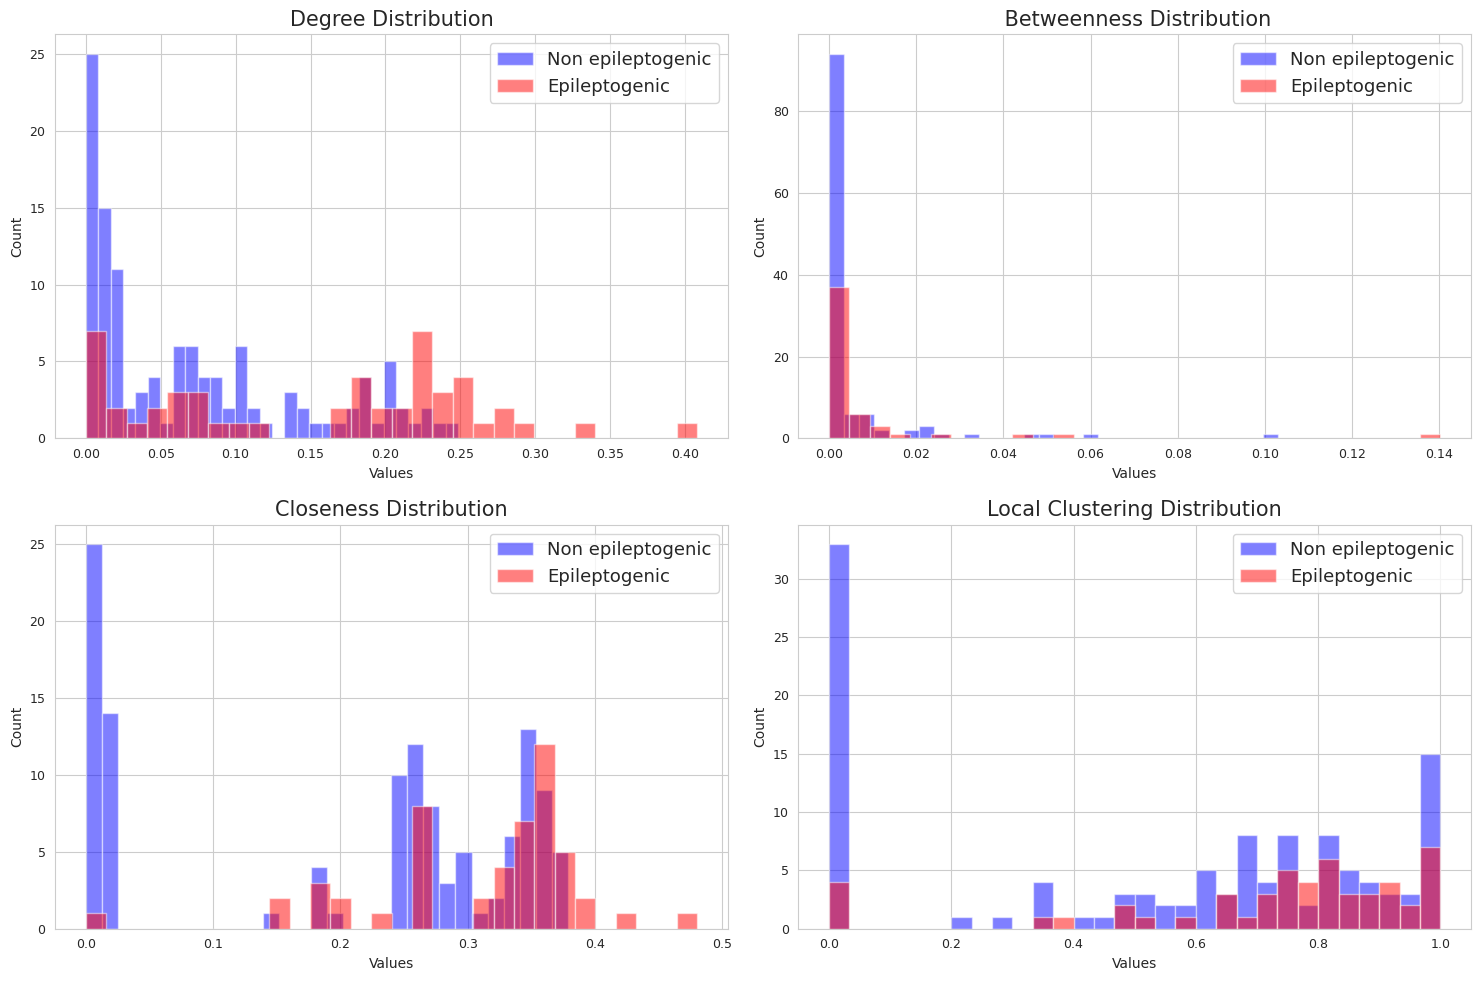

Betweenness   U Statistic: 0.37147800296589223, p-value: 0.007339363689226498
Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.
Closeness   U Statistic: 0.2701433514582304, p-value: 2.1113817639024054e-06
Le due distribuzioni sono significativamente diverse.
Degree   U Statistic: 0.2619047619047619, p-value: 8.552863731535239e-07
Le due distribuzioni sono significativamente diverse.
Local Clustering   U Statistic: 0.35615422639644095, normalized p-value: 0.002837147271714039
Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.


In [36]:
#----------------------------MISURE DI CENTRALITA'------------------------------

degree_centrality = nx.degree_centrality(G_max)
betweenness_centrality = nx.betweenness_centrality(G_max)
closeness_centrality = nx.closeness_centrality(G_max)
local_clustering = nx.clustering(G_max)


data = []
for node in G_max.nodes():
    label = G_max.nodes[node]['label']
    degree = degree_centrality[node]
    betweenness = betweenness_centrality[node]
    closeness = closeness_centrality[node]
    local_cl = local_clustering[node]
    data.append([node, label, degree, betweenness, closeness,local_cl])

df = pd.DataFrame(data, columns=['Nodo', 'Label', 'Degree', 'Betweenness', 'Closeness','Local Clustering'])

# Filtro i dati per label_0 e label_1
df_label_0 = df[df['Label'].isin(labels_0)]
df_label_1 = df[df['Label'].isin(labels_1)]


fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Degree Distribution
axs[0, 0].hist(df_label_0['Degree'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[0, 0].hist(df_label_1['Degree'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[0, 0].set_title('Degree Distribution')
axs[0, 0].set_xlabel('Values')
axs[0, 0].set_ylabel('Count')
axs[0, 0].legend()

# Betweenness Distribution
axs[0, 1].hist(df_label_0['Betweenness'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[0, 1].hist(df_label_1['Betweenness'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[0, 1].set_title(' Betweenness Distribution')
axs[0, 1].set_xlabel('Values')
axs[0, 1].set_ylabel('Count')
axs[0, 1].legend()

# Closeness Distribution
axs[1, 0].hist(df_label_0['Closeness'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[1, 0].hist(df_label_1['Closeness'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[1, 0].set_title('Closeness Distribution')
axs[1, 0].set_xlabel('Values')
axs[1, 0].set_ylabel('Count')
axs[1, 0].legend()

# Distribuzione combinata di Degree, Betweenness e Closeness
axs[1, 1].hist(df_label_0['Local Clustering'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[1, 1].hist(df_label_1['Local Clustering'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[1, 1].set_title('Local Clustering Distribution')
axs[1, 1].set_xlabel('Values')
axs[1, 1].set_ylabel('Count')
axs[1, 1].legend()

plt.tight_layout()

min1=my_range[max_position]
min2=my_range[max_position+1]
nome_file=f'plots_centrality_measures({min1}-{min2}Hz).jpg'
percorso_completo = os.path.join(cartella, nome_file)
plt.savefig(percorso_completo, format='jpg', dpi=300)
plt.show()



#------------------------------------------------
n1 = len(df_label_0['Local Clustering'])
n2 = len(df_label_1['Local Clustering'])

u_stat_b, p_value_b = mannwhitneyu(df_label_0['Betweenness'], df_label_1['Betweenness'])
u_statistic_normalized_b=u_stat_b/(n1*n2)
print(f"Betweenness   U Statistic: {u_statistic_normalized_b}, p-value: {p_value_b}")
if u_statistic_normalized_b < 0.3 or u_statistic_normalized_b>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")
    
u_stat_c, p_value_c = mannwhitneyu(df_label_0['Closeness'], df_label_1['Closeness'])
u_statistic_normalized_c=u_stat_c/(n1*n2)
print(f"Closeness   U Statistic: {u_statistic_normalized_c}, p-value: {p_value_c}")
if u_statistic_normalized_c < 0.3 or u_statistic_normalized_c>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")
    
u_stat_s, p_value_s = mannwhitneyu(df_label_0['Degree'], df_label_1['Degree'])
u_statistic_normalized_s=u_stat_s/(n1*n2)
print(f"Degree   U Statistic: {u_statistic_normalized_s}, p-value: {p_value_s}")
if u_statistic_normalized_s < 0.3 or u_statistic_normalized_s>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")

u_stat_cl, p_value_cl = mannwhitneyu(df_label_0['Local Clustering'], df_label_1['Local Clustering'])
u_statistic_normalized_cl=u_stat_cl/(n1*n2)
print(f"Local Clustering   U Statistic: {u_statistic_normalized_cl}, normalized p-value: {p_value_cl}")
if u_statistic_normalized_cl < 0.3 or u_statistic_normalized_cl>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")


In [82]:
data_ok = []
for node in G.nodes():
    label = G.nodes[node]['label']
    degree = degree_centrality[node]
    closeness = closeness_centrality[node]
    data_ok.append([node, label, degree, closeness])

df_ok = pd.DataFrame(data_ok, columns=['Nodo', 'Label', 'Degree', 'Closeness'])
print(df_ok)

filename = f"Max_v-score_Average_central measures_({my_range[max_position]}-{my_range[max_position+1]}Hz).csv"
percorso_completo = os.path.join(cartella, filename)
df_ok.to_csv(percorso_completo, index=False)

     Nodo Label    Degree  Closeness
0       0    A1  0.153846   0.247541
1       1   A10  0.088757   0.224606
2       2   A11  0.094675   0.225326
3       3   A12  0.059172   0.213036
4       4   A13  0.041420   0.196924
..    ...   ...       ...        ...
165   165    Z2  0.112426   0.239122
166   166    Z3  0.094675   0.232787
167   167    Z4  0.088757   0.228996
168   168    Z5  0.195266   0.251978
169   169    Z6  0.213018   0.256576

[170 rows x 4 columns]
